# ToDo: 
+ ~~期待値がほぼ 0 になっている理由を探す。回避できるようなら回避~~
+ ~~C = 3 * n_qubits の理由~~ (特に理由はない？)
+ ~~QPU のばらつき改善~~
+ ~~2 次のトロッターにしてみる~~
+ ~~GHZ を中心に寄せる。このままだと不要な Trotter gate があるので。~~
+ 不要な interaction を削除

## わかったこと
+ ハミルトニアンをシフトさせなければ成功
+ times = [2 * np.pi * k / C for k in range(n_features)] は失敗
+ times = [np.pi * k / C for k in range(n_features)] は成功

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
# Set up the Qiskit Runtime service (this is a one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

In [5]:
# Option1: Use IBM Quantum backend.
# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure', 'reset', 'x', 'id', 'cz', 'sx']>)


# データセット作成 $f(H) = e^{-\beta H}$

In [6]:
n_samples = 70
n_qubits = 12
beta = 1

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

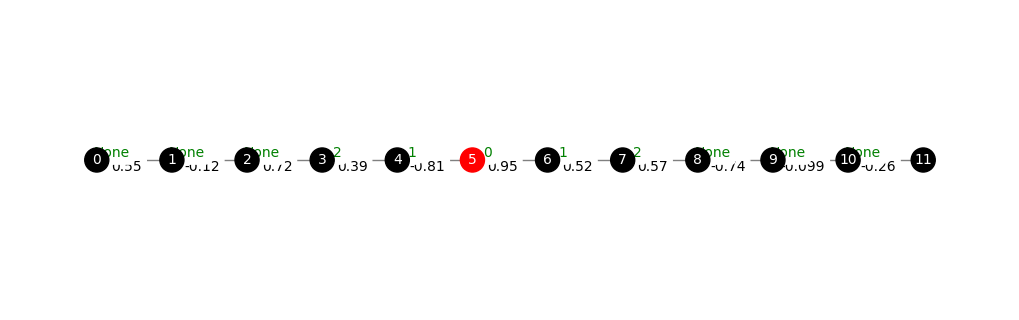

In [7]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [8]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
print(f"binary index: {index}")
state = Statevector.from_label(index)

print(f"decimal: {int(index, 2)}")
print(state[int(index, 2)])

binary index: 000111111000
decimal: 504
(1+0j)


## Non Trotter simulation (directly compute the expectation value)

In [9]:
data = []
graphs = []
# For debugging
# eigvals_abs_max = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H
    # H = H.to_matrix(sparse=True)

    # state is big endian, so we need to reverse the qubits of the Hamiltonian
    H = Operator(H).reverse_qargs().to_matrix()
    H = scipy.sparse.csr_matrix(H)
    norm = scipy.sparse.linalg.norm(H, ord=2)

    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y, "norm": norm})
    graphs.append(G)

    # For debugging
    # eigvals_abs_max.append(max(np.abs(scipy.linalg.eigvals(H.toarray()))))

df = pd.DataFrame(data)
df

Sample 0/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.0115881]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.011588096477614435.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.0115881]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve

Sample 1/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01771517]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.017715169975434517.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01771517]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 2/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.10718395]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.10718394946356402.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.10718395]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 3/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.03435486]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.03435485973788856.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.03435486]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 4/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.22378777]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.2237877712772859.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.22378777]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 5/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.15873707]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.133941845160289.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.13394185]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 6/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.17083013]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.12036983962798463.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.12036984]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 7/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.56454186]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.5645418604586305.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.56454186]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 8/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00033668]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.0003366766952463948.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00033668]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 9/70
Sample 10/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.17632061]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 14 instead with accuracy 
0.15841681042258254.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.15841681]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 11/70
Sample 12/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00996658]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.009966579463263955.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00996658]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 13/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.53911772]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.303511220514694.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.30351122]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 14/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.19052288]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.19052288365138237.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.19052288]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 15/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.43653896]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.43653896215881244.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.43653896]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 16/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.26744303]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 13 instead with accuracy 
0.07117757851132257.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.07117758]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 17/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00583474]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.00583473901790811.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00583474]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 18/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00314777]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.0031477676695032225.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00314777]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 19/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.11393842]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 17 instead with accuracy 
0.08884967189852351.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.08884967]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 20/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00916346]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.0074944229653397774.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00749442]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 21/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.20526108]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.10051335555842165.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.10051336]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 22/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.19536201]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.17832332254304648.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.17832332]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 23/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.06720481]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.06720480916249107.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.06720481]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 24/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.21719872]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.2171987220825411.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.21719872]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 25/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01518194]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.01518193821295293.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01518194]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 26/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.57691271]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 14 instead with accuracy 
0.06555508075722194.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.06555508]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 27/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00217292]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.0021729181322495536.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00217292]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 28/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.06633067]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.06633067376247381.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.06633067]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 29/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.03445955]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.013821358245921081.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01382136]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 30/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00378169]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.0037816908824561627.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00378169]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 31/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.03541535]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 16 instead with accuracy 
0.023450446170326787.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.02345045]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 32/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.10453437]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.0850839230662856.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.08508392]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 33/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02241721]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.022417214185775435.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.02241721]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 34/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.19536436]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.09397585200463779.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.09397585]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 35/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00818523]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.008185234907586037.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00818523]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 36/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.1403403]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.14034029585049818.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.1403403]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 37/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.11192212]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.10493677835820084.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.10493678]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 38/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.04579446]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.045794463673177147.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.04579446]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 39/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.04326063]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.04326063485267965.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.04326063]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 40/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01729145]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.017291454866874174.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01729145]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 41/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.49575053]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 16 instead with accuracy 
0.08998616642254302.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.08998617]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 42/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.36030322]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.2921557533315702.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.29215575]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 43/70
Sample 44/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.15690981]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 16 instead with accuracy 
0.136812130837152.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.13681213]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 45/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00073755]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.0005061592838713969.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00050616]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 46/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.06145458]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.061454577953720516.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.06145458]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 47/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[1.21498314]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 17 instead with accuracy 
0.9991482214253334.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.99914822]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 48/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02045197]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.020451973891096157.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.02045197]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 49/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.14712069]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.14712068762020103.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.14712069]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 50/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.02757493]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.027574929517122253.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.02757493]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 51/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.03775013]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.03775012615695801.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.03775013]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 52/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.24435517]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 17 instead with accuracy 
0.035135069709972724.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.03513507]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 53/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.25546133]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.2554613324243129.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.25546133]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 54/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01938878]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.012180435187240718.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01218044]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 55/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.11041993]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.11041993311101726.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.11041993]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 56/70
Sample 57/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.07432352]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.07432351892226563.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.07432352]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 58/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00604326]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.006043263125318011.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00604326]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 59/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.27422569]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 15 instead with accuracy 
0.14485452852665837.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.14485453]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 60/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00182723]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.001827231600812505.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00182723]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 61/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00277756]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.002760740316936904.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00276074]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 62/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00530327]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 19 instead with accuracy 
0.004519469548479041.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00451947]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 63/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00610708]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.006107078035774233.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00610708]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 64/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.14704215]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.14704215089670183.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.14704215]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 65/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.16417855]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.16417854840720797.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.16417855]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 66/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00455601]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.004556012069851703.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00455601]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 67/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.354651]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 15 instead with accuracy 
0.0700708030942214.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.0700708]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 68/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.05855191]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 20 instead with accuracy 
0.05725827443334758.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.05725827]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


Sample 69/70


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.01592472]
not reaching the requested tolerance 6.103515625e-05.
Use iteration 21 instead with accuracy 
0.015924720345502297.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.01592472]
not reaching the requested tolerance 6.103515625e-05.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


,Js,expected_value,norm
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",1.557428,9.901511
1,"[0.8535299776972036, 0.2877302401613291, 0.645...",4.323829,9.451757
2,"[0.9413960487898065, 0.7862422426443954, 0.556...",13.987062,10.795326
3,"[-0.25908058793026223, -0.06088837744838416, -...",16.139494,7.500441
4,"[0.6645196027904021, 0.6095287149936037, -0.22...",3.728221,8.949773
...,...,...,...
65,"[-0.6296413100928648, 0.12434146747514441, -0....",59.621119,11.905976
66,"[-0.5078667769901231, -0.8689391321632352, -0....",59.795468,11.652270
67,"[-0.395856862432723, -0.21174844564380502, -0....",19.171120,9.413636
68,"[0.5611622750531686, 0.6824074124299129, -0.47...",1.087973,9.153248


## Pre-process data

In [10]:
df["expected_value"].describe()

count     70.000000
mean      15.468866
std       40.997893
min        0.057524
25%        1.498523
50%        3.938971
75%       13.958430
max      320.819950
Name: expected_value, dtype: float64

In [11]:
df["norm"].describe()

count    70.000000
mean      9.630866
std       1.727463
min       5.911367
25%       8.350066
50%       9.760569
75%      10.953199
max      13.126572
Name: norm, dtype: float64

In [12]:
# Query the 80% quantile
q = df["expected_value"].quantile(0.8)
filtered_index = df.query(f"expected_value < @q").index
diffrence = df.index.difference(filtered_index)
print(f"Outliers: {diffrence}")

# Remove outliers
df = df.drop(diffrence).reset_index(drop=True)
graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

Outliers: Index([3, 11, 13, 15, 18, 23, 24, 34, 38, 48, 50, 65, 66, 67], dtype='int64')


In [13]:
display(df)

n_samples = len(df)
print(f"Number of samples: {n_samples}")
df["expected_value"].describe()

,Js,expected_value,norm
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",1.557428,9.901511
1,"[0.8535299776972036, 0.2877302401613291, 0.645...",4.323829,9.451757
2,"[0.9413960487898065, 0.7862422426443954, 0.556...",13.987062,10.795326
3,"[0.6645196027904021, 0.6095287149936037, -0.22...",3.728221,8.949773
4,"[0.5614580620439358, -0.08216844892332009, 0.1...",4.634752,6.295602
5,"[0.11841432149082709, -0.3920998038747756, -0....",6.514767,9.866210
6,"[0.3238330294537901, 0.11406430468255668, 0.56...",4.442313,7.956945
7,"[-0.6774564419327964, 0.0020895502067270755, -...",11.866389,9.692378
8,"[0.9237953290990291, 0.8171613814152141, 0.399...",0.101123,12.124840
9,"[-0.08844742033277786, -0.5952732704095394, -0...",0.321470,6.242837


Number of samples: 56


count    56.000000
mean      4.520066
std       4.699656
min       0.057524
25%       1.060135
50%       2.735529
75%       5.373565
max      16.069970
Name: expected_value, dtype: float64

In [ ]:
df["norm"].describe()

count    56.000000
mean      9.453443
std       1.670252
min       5.911367
25%       8.117396
50%       9.681111
75%      10.616041
max      12.696481
Name: norm, dtype: float64

## Check eigvals and Configure params

In [15]:
n_features = 10  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
# C = 10 * n_qubits  # upper bound for eigenvalues
C = max(df["norm"])
times = [np.pi * k / C for k in range(n_features)]

print(f"C: {C}")
print(f"times: {times}")

C: 12.696480593257155
times: [0.0, 0.24743806998438841, 0.49487613996877683, 0.7423142099531652, 0.9897522799375537, 1.237190349921942, 1.4846284199063304, 1.7320664898907188, 1.9795045598751073, 2.226942629859496]


In [16]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [17]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{CURRENT_TIME}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2024-12-13T08:56Z
Saving data to ./data/2024-12-13T08:56Z


In [18]:
# Save parameters

# Save the graphs as a binary file
with open(f"{path}/params_object.pkl", "wb") as f:
    pickle.dump(
        {
            "graphs": graphs,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "graph_type": graph_type,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
        },
        f,
        indent=4,
    )